# Integrate a simulated mosaic dataset

In this notebook, we used SpaMosaic to integrate a simulated mosaic dataset. It has three sections where the first section consists of RNA and protein modalities while the second only has RNA expression and the third only has protein expression. The simulated data has a ground truth of four spatial factors and a backgroun factor. For the simulated dataset, we reduced the RNA expression of factor 1 and protein expression of factor 4 to simulate a scenario where these factors were missing in their modalities. We also simulated batch effects between sections 1 and 2 in the RNA modality and sections 1 and 3 in the protein modality. For more details, please refer to our manuscript ([SpaMosaic, bioRxiv. 2024](https://www.biorxiv.org/content/10.1101/2024.10.02.616189v1)). 

Data used in this notebook can be downloaded from [google drive](https://drive.google.com/drive/folders/1m04mgkxXBo2in5Cq9Dv9fymwtA5V72IY?usp=drive_link).

In [1]:
import os
import scanpy as sc
from os.path import join

from spamosaic.framework import SpaMosaic

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # for CuBLAS operation and you have CUDA >= 10.2
import spamosaic.utils as utls
from spamosaic.preprocessing import RNA_preprocess, ADT_preprocess, Epigenome_preprocess

In [2]:
ad1_rna = sc.read_h5ad('./s1_adata_rna.h5ad')
ad1_adt = sc.read_h5ad('./s1_adata_adt.h5ad')
ad2_rna = sc.read_h5ad('./s2_adata_rna.h5ad')
ad3_adt = sc.read_h5ad('./s3_adata_adt.h5ad')

Set the batch labels for each section. `src` is the key in row metadata mapped to the batch labels.

In [4]:
ad1_rna.obs['src'] = ad1_adt.obs['src'] = ['mult'] * ad1_rna.n_obs
ad2_rna.obs['src'] = ['rna'] * ad2_rna.n_obs
ad3_adt.obs['src'] = ['adt'] * ad3_adt.n_obs

for ad in [ad1_rna, ad1_adt, ad2_rna, ad3_adt]:
    ad.X = ad.layers['counts'].copy()

### preprocessing

SpaMosaic expects <b>batch-corrected low-dimensional representations </b> for each modality as input. Therefore, for the raw count assays of each modality, SpaMosaic performs feature selection and dimension reduction to obtain the low-dimensional representations. Then, Harmony is performed to integrate these representations in each modality (<b>optional</b>, depending on the presence of strong batch effects). 

In mosaic integration, SpaMosaic requires the input dataset in the following format:
``` Python
{
    'rna':      [adata1_rna, adata2_rna,   None,         adata4_rna, ...],
    'protein':  [adata1_adt, None,         adata3_adt,   None,       ...],
    'atac':     [None,       adata2_atac,  None,         None,       ...],
    'histone':  [None,       None      ,   adata3_hist,  None,       ...],
    ...
}
```

In the dictionary, each key represents a modality and each modality key corresponds to list of `anndata` objects. Each `anndata` object contains modality-specific information for a particular section. For example, the first object `adata1_rna` under the 'rna' key holds the RNA profiles for the first section, while the first object `adata1_adt` under the 'protein' key holds protein profiles for the same section. If a section is not measured for a particular modality, its value in the list is `None`. For instance, the first element under the 'atac' and 'histone' keys is `None`, indicating that the first section was not measured with ATAC or histone modality. All lists have the same length, which corresponds to the number of sections in the target dataset.

SpaMosaic employs contrastive learning to capture the relationships  between modalities. To achieve this, it requires the modalities in a mosaic dataset to be directly or indirectly connected through one or multiple sections. If a pair of modalities occur in the same section, there is a direct connection between this pair of modalities, while an indirect connection requires multiple intermediary direct connections. 

#### 1. Check batch effects

In [5]:
input_dict = {
    'rna': [ad1_rna, ad2_rna, None],
    'adt': [ad1_adt, None,    ad3_adt]
}

RNA_preprocess(input_dict['rna'], batch_corr=False, favor='scanpy', n_hvg=None, lognorm=True, scale=True, batch_key='src', key='X_pca')
ADT_preprocess(input_dict['adt'], batch_corr=False, favor='scanpy', lognorm=True, scale=True, batch_key='src', key='X_pca')

Visualize the preprocessed low-dimensional representations in UMAP. Spots are colored by batch label and ground truth factor label.

/home/yanxh/anaconda3/envs/spamosaic-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


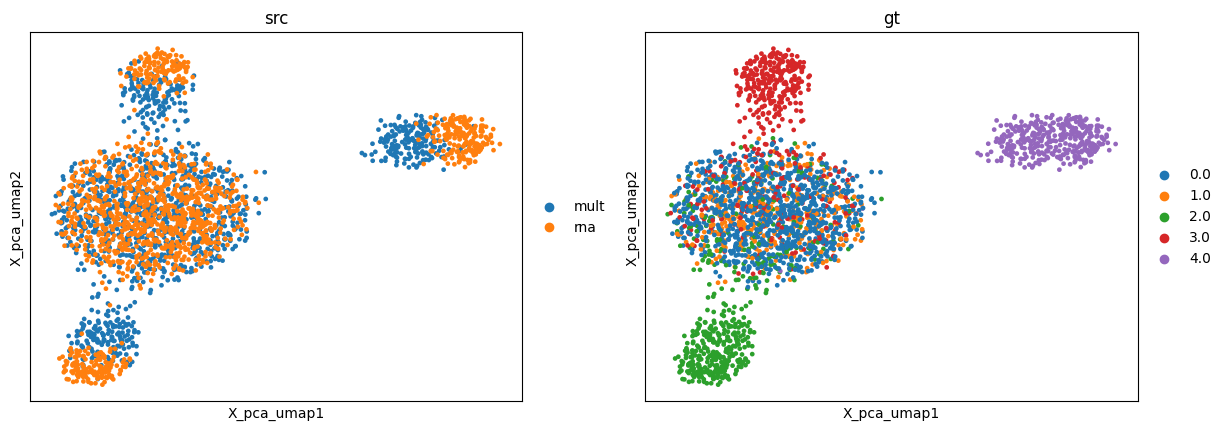

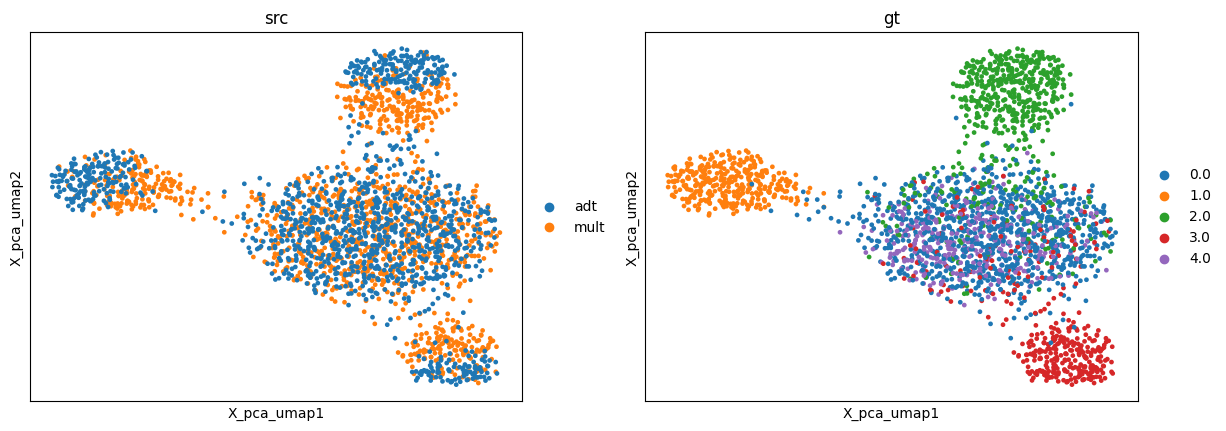

In [6]:
ad_rna_concat = sc.concat([input_dict['rna'][0], input_dict['rna'][1]])
ad_adt_concat = sc.concat([input_dict['adt'][0], input_dict['adt'][2]])

ad_rna_concat = utls.get_umap(ad_rna_concat, ['X_pca'])
ad_adt_concat = utls.get_umap(ad_adt_concat, ['X_pca'])

utls.plot_basis(ad_rna_concat, 'X_pca_umap', ['src', 'gt'])
utls.plot_basis(ad_adt_concat, 'X_pca_umap', ['src', 'gt'])

#### 2. batch correction

In [7]:
input_dict = {
    'rna': [ad1_rna, ad2_rna, None],
    'adt': [ad1_adt, None,    ad3_adt]
}

input_key = 'X_pca_be'

In [8]:
RNA_preprocess(input_dict['rna'], batch_corr=True, favor='scanpy', n_hvg=None, lognorm=False, scale=True, batch_key='src', key=input_key)
ADT_preprocess(input_dict['adt'], batch_corr=True, favor='scanpy', lognorm=False, scale=True, batch_key='src', key=input_key)

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).
Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
Reach convergence after 9 iteration(s).


### training

SpaMosaic employs modality-specific graph neural networks to embed each modality's input into latent space. In horizontal integration, all sections have only one modality, thus each section has only one set of embeddings. 

The crucial parameters include:
- `intra_knns`: how many nearest neighbors to consider when searching for spatial neighbors within each section (list or integer)
- `inter_knn_base`: how many nearest neighbors to consider when searching for mutual nearest neighbors between sections (integer)
- `w_g`: the weight for spatial-adjacency graph

The following parameters are recommended to use in complex integration scenarios, like varying resolution or size across sections
- `smooth_input`: whethere to smooth the input representations (bool)
- `smooth_L`: number of LGCN layers for smoothing input
- `inter_auto_knn`: whether to automatically balance the kNN during MNN searching (bool)
- `rmv_outlier`: whether to remove outlier of MNN (bool)
- `contamination`: percentage of removed MNN outlier

for training:
- `net`: which graph neural network to use (only support wlgcn now)
- `lr`: learning rate
- `n_epochs`: number of training epochs
- `w_rec_g`: the loss weight for reconstructing original graph structure. If the target dataset contains protein modality, we recommend a low value for w_rec_g (e.g., 0); if it contains epigenome modality, we recommend a high value for w_rec_g (e.g., 1).

In [9]:
model = SpaMosaic(
    modBatch_dict=input_dict, input_key=input_key,
    batch_key='src', intra_knns=10, inter_knn_base=10, w_g=0.8, 
    seed=1234, 
    device='cuda:0'
)

model.train(net='wlgcn', lr=0.01, T=0.1, n_epochs=100)

batch0: ['rna', 'adt']
batch1: ['rna']
batch2: ['adt']
------Calculating spatial graph...
The graph contains 12960 edges, 1296 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 12960 edges, 1296 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 12960 edges, 1296 cells.
10.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 12960 edges, 1296 cells.
10.0000 neighbors per cell on average.
Searching MNN within rna
Finding MNN between (mult, rna) using KNN (10, 10)
Number of mnn pairs for rna:4342
Searching MNN within adt
Finding MNN between (mult, adt) using KNN (10, 10)
Number of mnn pairs for adt:5300


100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.95it/s]


### inference

After training, SpaMosaic can infer the modality-specific embedding for each section. These embeddings will be directly saved in original `anndata` objects. For example, the RNA-specific embeddings can be accessed by `ad1_rna.obsm['emb']`, `ad2_rna.obsm['emb']`, the protein-specific embeddings can be accessed by `ad1_adt.obsm['emb']`, `ad3_adt.obsm['emb']`.

The following `infer_emb` function will return a <b>new</b> list of `anndata` objects, which save the final/merged embeddings for spatial clustering. The final embeddings can be accessed by `ad_embs[0].obsm['merged_emb']`, `ad_embs[1].obsm['merged_emb']`, ...

In mosaic integration, the final merged embeddings are obtained by averaging the modality-specific embeddings.

In [10]:
ad_embs = model.infer_emb(input_dict, emb_key='emb', final_latent_key='merged_emb')
ad_mosaic = sc.concat(ad_embs)
ad_mosaic = utls.get_umap(ad_mosaic, use_reps=['merged_emb'])

Visualize the final embeddings using UMAP plots, spot are colored by batch labels

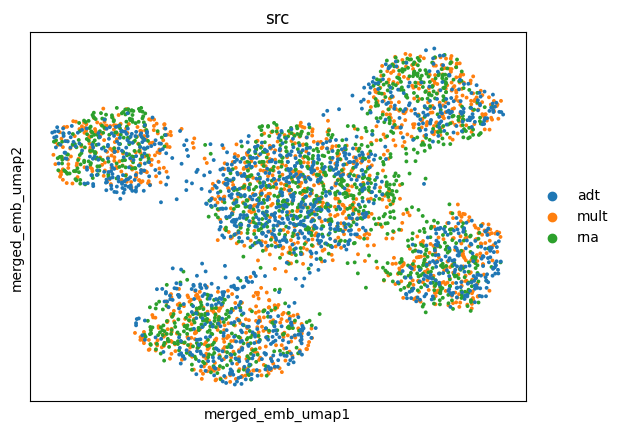

In [11]:
utls.plot_basis(ad_mosaic, basis='merged_emb_umap', color=['src'])

### clustering

Parameters for the following `utls.clustering` function:
- `n_cluster`: expected number of clusters
- `used_obsm`: the target key in the `ad_mosaic.obsm` that holds the embeddings for clustering input
- `algo`: which clustering algorithm to use, `mclust` or `kmeans`. Sometimes `mclust` can fail to output clustering, it will automatically output the `kmeans` outputs.
- `key`: the key in the row metadata that will hold the output clustering labels.

Generally, SpaMosaic works better with the mclust algorithm in spatial domain identification task, but for the simulated dataset, we found that mclust and kmeans resulted in similar performance. The final/merged embeddings are used as input for clustering and the clustering labels can be accessed by `ad_mosaic.obs['kmeans']`.

In [12]:
utls.clustering(ad_mosaic, n_cluster=5, used_obsm='merged_emb', algo='kmeans', key='kmeans')
utls.split_adata_ob(ad_embs, ad_mosaic, 'obs', 'kmeans')

/home/yanxh/anaconda3/envs/spamosaic-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Spatial plots of clustering label for individual sections

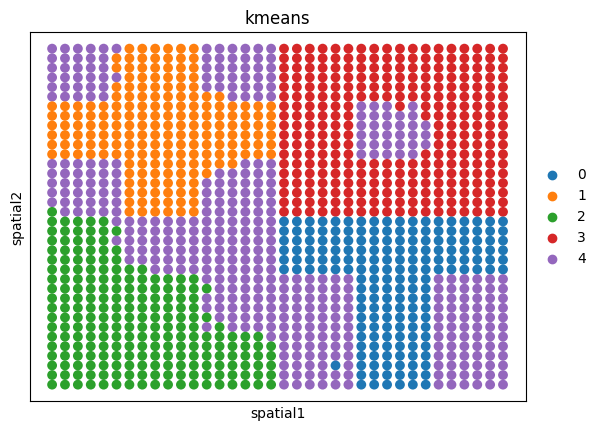

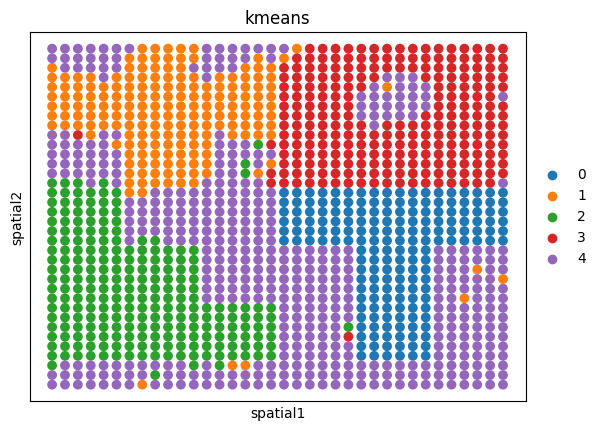

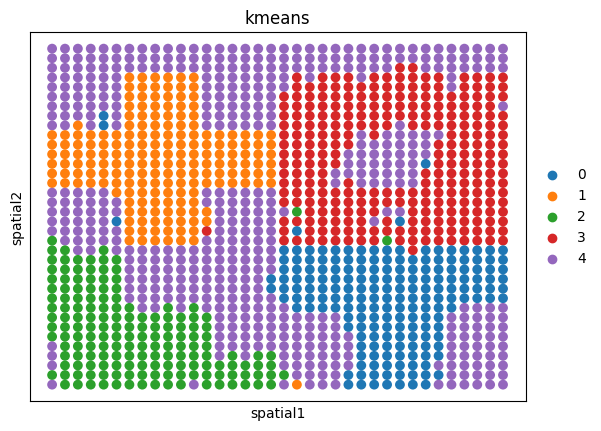

In [13]:
for ad in ad_embs:
    utls.plot_basis(ad, 'spatial', 'kmeans', s=200)